In [58]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [59]:
import numpy as np
import pandas as pd
import datetime as dt
from pprint import pprint
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [60]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [61]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [62]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [63]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [64]:
# Save references to each table
measurement = Base.classes.measurement
Station = Base.classes.station

In [65]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [66]:
# Find the most recent date in the data set.
engine.execute('SELECT max(date) FROM measurement').fetchall()

[('2017-08-23',)]

In [67]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
# last_date = dt.datetime.strptime(last_date, "%y-%m-%d")

# Calculate the date one year from the last date in data set.
# last_year = last_date - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores

# precip_results = (
#    session.query(measurement.date,measurement.precip)
#    .filter(measurement.date > last_year)
#    .order_by(measurement.date)
#    .all()
#)
# Save the query results as a Pandas DataFrame and set the index to the date column
#precip_df = pd.DataFrame(precip_results,columns = ["Date", "Precipitaion"])

# Sort the dataframe by date
# precip_df["Date"] = pd.to_datetime(precip_df["Date"])
# precip_df = precip_df.sort_values("Date").dropna().set_index("Date")




In [68]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.
# precipitation_data = session.query(func.strftime("%y-%m-%d", measurement.date),measurement.prcp).\
#    filter(func.strftime("%y-%m-%d",measurement.date) >=dt.date(2016, 8, 23)).all()
# Save the query results as a Pandas DataFrame and set the index to the date column

#precipitation_df = pd.DataFrame(precipitation_data ,columns = ["Date", "Precipitaion"])


In [69]:
# set index
# precipitation_df.set_index('date', inplace=True)
#precipitation_df["Date"] = pd.to_datetime(precipitation_df["Date"])

# Sort the dataframe by date
#precipitation_df = precipitation_df.sort_values("Date").dropna().set_index("Date")

# Use Pandas to calcualte the summary statistics for the precipitation data
# precipitation_df.head()
#precipitation_df.describe()

In [70]:
precipitation_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= "2016-08-24").\
    filter(measurement.date <= "2017-08-23").all()
prcp_df = pd.DataFrame(precipitation_data).set_index('date')
prcp_df=prcp_df.rename(columns={'prcp':'precipitaion'})

prcp_df =prcp_df.sort_values(by='date').dropna()
prcp_df.head()

KeyError: "None of ['date'] are in the columns"

In [31]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(color="blue", figsize=(9, 8))
plt.title("precipitation Data for last 12 months")
plt.ylabel("precipitation (mm)")
plt.xlabel("")
plt.savefig(precip.png)

TypeError: no numeric data to plot

# Exploratory Station Analysis

In [36]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station.id).distinct().count()
stations

9

In [37]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

station_count = (session.query(measurement.station, func.count(measurement.station))
                .group_by(measurement.station)
                .order_by(func.count(measurement.station).desc())
                .all())
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [39]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = 'USC00519281'
temp = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_station).all()
temp

[(54.0, 85.0, 71.66378066378067)]

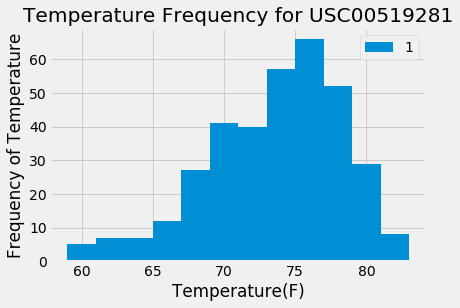

In [51]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_observation = station_count[0][0]
results = session.query(measurement.date, measurement.tobs).\
                        filter(measurement.date >= "2016-08-24").\
                        filter(measurement.date <= "2017-08-23").\
                        filter(measurement.station == temp_observation).all()
results_df = pd.DataFrame(results)

results_df.plot.hist(bins=12)
plt.ylabel("Frequency of Temperature")
plt.xlabel("Temperature(F)")
plt.title("Temperature Frequency for USC00519281")

plt.savefig("histogram.png")

# Close session

In [52]:
# Close Session
session.close()